In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

from quickstats.plots import Likelihood1DPlot, Likelihood2DPlot, UpperLimit3DPlot
from quickstats.utils.common_utils import combine_dict
from quickstats.maths.numerics import is_integer, pretty_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from scipy.interpolate import interp1d
def get_interval(df, level):
    xvalues = df['mu'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    x_new = np.arange(min(xvalues), max(xvalues), 0.01)
    y_new = func_theory(x_new)
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    intersections = x_new[signchange==1]
    return intersections

statuses = ['int', 'final']

from quickstats.maths.interpolation import get_intersections


## kl 1D

In [3]:
import uproot
import pandas as pd
from pdb import set_trace

def data_loading_lh(job, cut=1000):
    likelihood_df = {}

    file = uproot.open(f"HHHresults/kl_1D_michigan/nllscan_WS-Comb-k3_{job}.root")
    for chan in ['singleH', 'diHiggs', 'HHH', 'generic']:
        graph_name = {
            'singleH': 'H k3 only',
            'diHiggs': 'HH k3 only',
            'HHH': 'HH+H k3 only',
            'generic': 'HH+H k3 generic',
        }
        graph = {'mu': file[graph_name[chan]].all_members['fX'].byteswap().newbyteorder(),
                     'qmu': file[graph_name[chan]].all_members['fY'].byteswap().newbyteorder()}
        df_scan = pd.DataFrame(graph)
        df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
        likelihood_df[chan] = df_scan
        
#     file = uproot.open(f"kl_1D_michigan/nllscan_WS-Comb-k3Fixk2V.root")
#     graph_name = f'k3 - k2V=1 ({job})'
#     graph = {'mu': file[graph_name].all_members['fX'].byteswap().newbyteorder(),
#              'qmu': file[graph_name].all_members['fY'].byteswap().newbyteorder()}
#     df_scan = pd.DataFrame(graph)
#     df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
#     likelihood_df['generic'] = df_scan
        
#     df_scan = pd.read_csv(f'kl_1D_michigan/generic_{job}_nok2V.csv').rename(columns={'mu': 'mu', 'nll': 'qmu'})
#     df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
#     likelihood_df['generic'] = df_scan
    return likelihood_df

likelihood_df = {}
for job in ['exp', 'obs']:
    likelihood_df[job] = data_loading_lh(job=job, cut=6)

In [81]:
likelihood_df['exp']['generic']

,mu,qmu
9,-2.750000,5.804203
10,-2.500000,4.924827
11,-2.250000,4.126865
12,-2.200000,3.976966
13,-2.150000,3.830219
14,-1.500000,2.206037
15,-1.250000,1.716494
16,-1.000000,1.297911
17,-0.750000,0.947051
18,-0.500000,0.660264


In [82]:
x1=7.5
y1=3.431141
x2=7.75
y2=4.113628
y3=3.84
print(x1+(y3-y1)*(x2-x1)/(y2-y1))

7.649768054190043


In [83]:
def plot_1D(likelihood_df, job, xmin = -6, xmax = 15, ymin=0, ymax = 10, xlabel=r"$\mathit{\kappa_{\lambda}}$", xattrib='mu', yattrib='qmu', status='int'):

    channel_label_map = {
        'singleH': r'$\mathit{H}\ \mathit{\kappa_{\lambda}}$ only',
        'diHiggs': r'$\mathit{HH}\ \mathit{\kappa_{\lambda}}$ only',
        'HHH': r'$\mathit{HH+H}\ \mathit{\kappa_{\lambda}}$ only',
        'generic': r'$\mathit{HH+H}\ \mathit{\kappa_{\lambda}}$ generic',
    }

    styles_map = {
        'singleH': {"color": 'b', "marker": ","},
        'diHiggs': {"color": "r", "marker": ","},
        'HHH': {"color": "k", "marker": ","},
        'generic': {"color": 'lawngreen', "marker": ","},
    }
#     styles_map = {
#         'singleH': {"color": 'b', "marker": "o"},
#         'diHiggs': {"color": "r", "marker": "^"},
#         'HHH': {"color": "k", "marker": "v"},
#         'generic': {"color": 'lawngreen', "marker": "o"},
#     }


    config = {
            'sigma_values': (1, 3.84),
            'sigma_levels': ('1sigma', '0.95'),
            'sigma_names': ('68%', '95%'),
            'sigma_pos': 0.89,
         }
    styles = {
        'legend': {
            'loc': (0.60, 0.66)
        },
        'plot': {
            'linewidth': 4,
        },
        'axis':{
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    }

    label_options = {
        'status': status,
        'loc': (0.05, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'extra_text': r'Expected SM' if job == 'exp' else r'Observed'
    }
    anno_op = {
        'x': 0.29,
        'y': 0.67,
        'dy': 0.065,
        'font_size': 19
    }

    plotter = Likelihood1DPlot(likelihood_df[job], label_map=channel_label_map, styles_map=styles_map, styles=styles, config = config, analysis_label_options=label_options)
    ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib=xattrib, yattrib=yattrib)

    intersections_1p = get_interval(likelihood_df[job]['HHH'], 1).tolist()
    intersections_2p = get_interval(likelihood_df[job]['HHH'], 3.84).tolist()
    intersections_3p = get_interval(likelihood_df[job]['generic'], 1).tolist()
    intersections_4p = get_interval(likelihood_df[job]['generic'], 3.84).tolist()
    print(intersections_4p)
    intersections_1 = get_intersections(likelihood_df[job]['HHH']['mu'].values, likelihood_df[job]['HHH']['qmu'].values, level=1, delta=0.0001)[0]
    intersections_2 = get_intersections(likelihood_df[job]['HHH']['mu'].values, likelihood_df[job]['HHH']['qmu'].values, level=3.84, delta=0.0001)[0]
    intersections_3 = get_intersections(likelihood_df[job]['generic']['mu'].values, likelihood_df[job]['generic']['qmu'].values, level=1, delta=0.0001)[0]
    intersections_4 = get_intersections(likelihood_df[job]['generic']['mu'].values, likelihood_df[job]['generic']['qmu'].values, level=3.84, delta=0.0001)[0]
#     if job == 'exp':
#         intersections_2[1] = 7.5
    print(job, 'kl only', intersections_2)
    print(job, 'kl generic', intersections_4)
    ax.annotate(f'{channel_label_map["HHH"]}:', 
                (anno_op['x'], anno_op['y']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
    ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                (anno_op['x'], anno_op['y'] - anno_op['dy']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
    ax.annotate(f'{channel_label_map["generic"]}:', 
                (anno_op['x'], anno_op['y'] - 2 * anno_op['dy']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
    ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_4[0], intersections_4[1]), 
                (anno_op['x'], anno_op['y'] - 3 * anno_op['dy']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
   
    savefolder = f'HHHresults/figures/{status}/'
    save = {
        'exp': f'H_HH_k2Vfixed_asimov_{status}.pdf',
        'obs': f'H_HH_k2Vfixed_data_{status}.pdf',
    }
    os.makedirs(savefolder, exist_ok=True)
    plt.savefig(savefolder + save[job], bbox_inches="tight")
    print('Save', savefolder + save[job])

[-1.3599999999999994, 6.100000000000007]
obs kl only [-0.40630004  6.30999996]
obs kl generic [-1.3616  6.0907]
Save HHHresults/figures/int/H_HH_k2Vfixed_data_int.pdf


<Figure size 432x288 with 0 Axes>

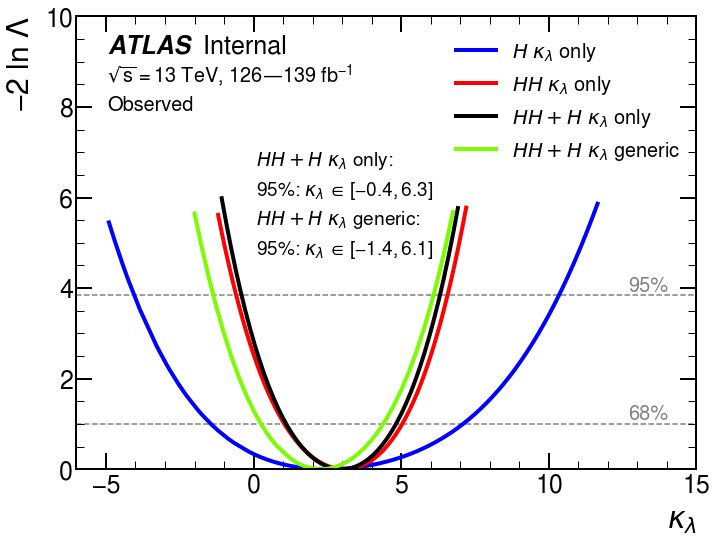

In [85]:
for status in statuses:
#     plot_1D(likelihood_df, job='exp', status=status)
    plot_1D(likelihood_df, job='obs', status=status)
    break


## 2D

In [7]:
def read():
    df_2D = {'exp': {}, 'obs': {}}
    df_2D['exp']['HHH'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/HHH_klVSkt_exp.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['HHH'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/HHH_klVSkt_obs.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['exp']['singleH'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/singleH_klVSkt_exp.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['singleH'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/singleH_klVSkt_obs.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['exp']['diHiggs'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/HHComb_klVSkt_exp.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['diHiggs'] = pd.read_csv('HHHresults/csv_withoutboosthbb_ihep/HHComb_klVSkt_obs.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
#     df_2D['exp']['diHiggs'] = pd.read_json('../outputs_HHH2022_20220520_with_BR_decorrelation/likelihood/expected/combined/klambda_kt_2D/klambda_kt.json') #.rename(columns={'k3': 'klambda', 'nll': 'qmu'})
#     df_2D['obs']['diHiggs'] = pd.read_json('../outputs_HHH2022_20220520_with_BR_decorrelation/likelihood/observed/combined/klambda_kt_2D/klambda_kt.json') #.rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    cut = 1.28
    df_2D['exp']['diHiggs'] = df_2D['exp']['diHiggs'].drop(df_2D['exp']['diHiggs'][df_2D['exp']['diHiggs']['kt']>cut].index)
    df_2D['obs']['diHiggs'] = df_2D['obs']['diHiggs'].drop(df_2D['obs']['diHiggs'][df_2D['obs']['diHiggs']['kt']>cut].index)
    df_2D['obs']['diHiggs'].apply(pretty_value)

    return df_2D

df_2D = read()
df_2D['exp']['singleH'].shape, df_2D['obs']['singleH'].shape

((2448, 3), (2448, 3))

In [8]:
# from matplotlib import rc
# rc('text', usetex=True)
# rc('font',**{'family':'sans-serif','sans-serif':['Tex Gyre Heros', 'Helvetica', 'Nimbus Sans', 'Arial']})

def plot_klambda_kt(df, job, status='int'):
    df_2D = df[job]
    labels = {
        'exp': r'All other $\mathit{\kappa}$'+' fixed to SM//Expected SM',
        'obs': r'All other $\mathit{\kappa}$'+' fixed to SM//Observed',
    }
#     labels = {
#         'exp': r'All other $\mathrm{\kappa}$'+' fixed to SM//Expected',
#         'obs': r'All other $\mathrm{\kappa}$'+' fixed to SM//Observed',
#     }
    save = {
        'exp': f'H_HH_HHH_kl_kt_2D_asimov_{status}.pdf',
        'obs': f'H_HH_HHH_kl_kt_2D_data_{status}.pdf',
    }
    label_options = {
#         'colab': r'$\textbf{\textit{ATLAS}}$',
        'status': status,
        'loc': (0.05, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'extra_text': labels[job],
    }
    config_map = {
        'HHH': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': (r'68% CL $\mathit{HH+H}$', r'95% CL $\mathit{HH+H}$'),
            'sigma_colors': ('k', 'k'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 1000,
        },
        'singleH': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': (r'68% CL $\mathit{H}$', r'95% CL $\mathit{H}$'),
            'sigma_colors': ('b', 'b'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 1000,
        },
        'diHiggs': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': (r'68% CL $\mathit{HH}$', r'95% CL $\mathit{HH}$'),
            'sigma_colors': ('r', 'r'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 1000,
        },
     }
    styles = {
        'legend': {
            'loc': (0.67, 0.52),
            'prop': {'size': 17},
        },
#         'plot': {
#             'linewidth': 15,
#         },
        'xlabel': {
            'fontsize': 30,
        },
        'axis': {
            'labelsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        }
    }

    styles_map = {
        'singleH': {"color": 'b', "marker": ","},
        'HHH': {"color": "#9A0EEA", "marker": ","},
        'diHiggs': {"color": "#008F00", "marker": ","},
    }
    label_map = {
        'singleH': '$\mathit{H}$',
        'HHH': '$\mathit{HH+H}$',
        'diHiggs': '$\mathit{HH}$',
    }

    x='klambda'
    y='kt'
    xlabel=r"$\mathit{\kappa_{\lambda}}$"
    ylabel=r"$\mathit{\kappa_{t}}$"
    best_fit_x, best_fit_y = {}, {}

    # plotter = Likelihood2DPlot(data_map=df_2D['singleH'], styles=styles, config = config['singleH'], analysis_label_options=label_options)
    # best_fit_x['singleH'] = df_2D['singleH'][x].iloc[df_2D['singleH']['qmu'].idxmin()]
    # best_fit_y['singleH'] = df_2D['singleH'][y].iloc[df_2D['singleH']['qmu'].idxmin()]
    # print(best_fit_x)
    # plotter.add_highlight(1, 1, label="SM prediction")
    # plotter.add_highlight(best_fit_x['singleH'], best_fit_y['singleH'], label=f"Best fit single H({best_fit_x['singleH']:.2f}, {best_fit_y['singleH']:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })
    # ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)

    show_colormesh=False
    ymin=0.86
    ymax=1.4
    xmin=-10
    xmax=20

    plotter = Likelihood2DPlot(data_map=df_2D, styles_map=styles_map, label_map=label_map, styles=styles, config_map=config_map, analysis_label_options=label_options)
#     plotter.add_highlight(1, 1, label="SM prediction", styles={'markerfacecolor':'k', 'color':'k', 'marker':(5, 1, 180), 'linestyle': None, 'linewidth': 0, 'markersize': 20})
    plotter.add_highlight(1, 1, label="SM prediction")
    for k in df_2D:
        best_fit_x[k] = df_2D[k][x].iloc[df_2D[k]['qmu'].idxmin()]
        best_fit_y[k] = df_2D[k][y].iloc[df_2D[k]['qmu'].idxmin()]
    print(best_fit_x, best_fit_y['HHH'])
    # plotter.add_highlight(best_fit_x['HHH'], best_fit_y['HHH'], label=f"Best fit HH+H({best_fit_x['HHH']:.2f}, {best_fit_y['HHH']:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })
    plotter.add_highlight(best_fit_x['HHH'], best_fit_y['HHH'], label=r"Best fit $\mathit{HH+H}$", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, 'markerfacecolor':'w' })
    ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)
    savefolder = f'HHHresults/figures/{status}/'
    os.makedirs(savefolder, exist_ok=True)
    plt.savefig(savefolder + save[job], bbox_inches="tight")

{'HHH': 2.875, 'singleH': 2.5, 'diHiggs': 4.5} 1.0
{'HHH': 1.0, 'singleH': 1.0, 'diHiggs': 3.5} 1.0
{'HHH': 2.875, 'singleH': 2.5, 'diHiggs': 4.5} 1.0
{'HHH': 1.0, 'singleH': 1.0, 'diHiggs': 3.5} 1.0


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

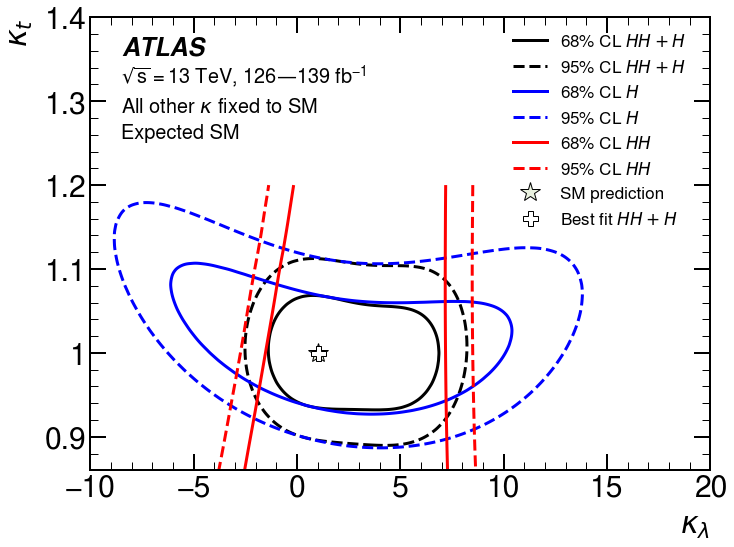

In [9]:
for status in statuses:
    plot_klambda_kt(df_2D, 'obs', status=status)
    plot_klambda_kt(df_2D, 'exp', status=status)


## k2V kV (in Auxiliary)

In [5]:
def read_k2VkV(chan='HH'):
    df_2D = {'exp': {}, 'obs': {}}
    df_2D['exp']['diHiggs'] = pd.read_csv(f'HHHresults/k2V_kV_apc/C3_FullSys_kV_k2V_{chan}_asimov.csv').rename(columns={'#kV': 'kV', 'nll': 'qmu'}).apply(pretty_value)
    df_2D['obs']['diHiggs'] = pd.read_csv(f'HHHresults/k2V_kV_apc/C3_FullSys_kV_k2V_{chan}_obs.csv').rename(columns={'#kV': 'kV', 'nll': 'qmu'}).apply(pretty_value)
    df_2D['exp']['diHiggs']['qmu'] *= 2
    df_2D['obs']['diHiggs']['qmu'] *= 2
#     cut = 1
#     df_2D['exp']['diHiggs'] = df_2D['exp']['diHiggs'].drop(df_2D['exp']['diHiggs'][df_2D['exp']['diHiggs']['qmu']>cut].index)

    return df_2D

df_2D_k2VkV = read_k2VkV()
df_2D_k2VkV['exp']['diHiggs'].head(5)

,kV,k2V,qmu
0,-1.10,1.5,7.943466
1,1.58,3.1,3.084028
2,1.90,1.3,38.620306
3,0.88,2.0,7.655458
4,-0.22,3.2,144.547178


In [6]:
def plot_k2v_kv(df, job, status='int'):
    df_2D = df[job]
    labels = {
        'exp': r'All other $\mathit{\kappa}$'+' fixed to SM//Expected SM',
        'obs': r'All other $\mathit{\kappa}$'+' fixed to SM//Observed',
    }
    save = {
        'exp': f'HH_kV_k2V_exp_{status}.pdf',
        'obs': f'HH_kV_k2V_obs_{status}.pdf',
    }
    label_options = {
        'status': status,
        'loc': (0.05, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'extra_text': labels[job],
    }
    config_map = {
#         'HHH': {
#             'sigma_levels': ('0.68', '0.95'),
#             'sigma_names': ('68% CL HH+H', '95% CL HH+H'),
#             'sigma_colors': ('k', 'k'),
#             'sigma_linestyles': ('solid', 'dashed'),
#             'interpolation': 'linear',
#             'num_grid_points': 70,
#         },
#         'singleH': {
#             'sigma_levels': ('0.68', '0.95'),
#             'sigma_names': ('68% CL H', '95% CL H'),
#             'sigma_colors': ('b', 'b'),
#             'sigma_linestyles': ('solid', 'dashed'),
#             'interpolation': 'cubic',
#             'num_grid_points': 30,
#         },
        'diHiggs': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': (r'68% CL $\mathit{HH}$', r'95% CL $\mathit{HH}$'),
            'sigma_colors': ('r', 'r'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 500,
        },
#         'diHiggs': {
#             'sigma_levels': ('0.5', '1', '1.5', '2', '0.68', '0.95'),
#             'sigma_names': ('0.5', '1', '1.5', '2',  r'68% CL $\mathit{HH}$', r'95% CL $\mathit{HH}$'),
#             'sigma_colors': ('b', 'b', 'g', 'g', 'r', 'r'),
#             'sigma_linestyles': ('solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed'),
#             'interpolation': 'cubic',
#             'num_grid_points': 500,
#         },
     }
    styles = {
        'legend': {
            'loc': (0.67, 0.05),
            'prop': {'size': 17},
        },
        'plot': {
            'linewidth': 3,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'axis': {
            'labelsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        }
    }

    styles_map = {
#         'singleH': {"color": 'b', "marker": ","},
#         'HHH': {"color": "#9A0EEA", "marker": ","},
        'diHiggs': {"color": "#008F00", "marker": ","},
    }
    label_map = {
#         'singleH': 'H',
#         'HHH': 'HH+H',
        'diHiggs': '$\mathit{HH}$',
    }

    x='k2V'
    y='kV'
    xlabel=r"$\mathit{\kappa_{2V}}$"
    ylabel=r"$\mathit{\kappa_{V}}$"
    best_fit_x, best_fit_y = {}, {}

    # plotter = Likelihood2DPlot(data_map=df_2D['singleH'], styles=styles, config = config['singleH'], analysis_label_options=label_options)
    # best_fit_x['singleH'] = df_2D['singleH'][x].iloc[df_2D['singleH']['qmu'].idxmin()]
    # best_fit_y['singleH'] = df_2D['singleH'][y].iloc[df_2D['singleH']['qmu'].idxmin()]
    # print(best_fit_x)
    # plotter.add_highlight(1, 1, label="SM prediction")
    # plotter.add_highlight(best_fit_x['singleH'], best_fit_y['singleH'], label=f"Best fit single H({best_fit_x['singleH']:.2f}, {best_fit_y['singleH']:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })
    # ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)

    show_colormesh=False
    ymin=-1.2
    ymax=2.4
    xmin=-1
    xmax=4.2

    plotter = Likelihood2DPlot(data_map=df_2D, styles_map=styles_map, label_map=label_map, styles=styles, config_map=config_map, analysis_label_options=label_options)
    plotter.add_highlight(1, 1, label="SM prediction", )
    for k in df_2D:
        best_fit_x[k] = df_2D[k][x].iloc[df_2D[k]['qmu'].idxmin()]
        best_fit_y[k] = df_2D[k][y].iloc[df_2D[k]['qmu'].idxmin()]
    plotter.add_highlight(best_fit_x['diHiggs'], best_fit_y['diHiggs'], label=r"Best fit $\mathit{HH}$", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, 'markerfacecolor':'w' })
    ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)
    savefolder = f'HHHresults/figures/{status}/'
    os.makedirs(savefolder, exist_ok=True)
    plt.savefig(savefolder + save[job], bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

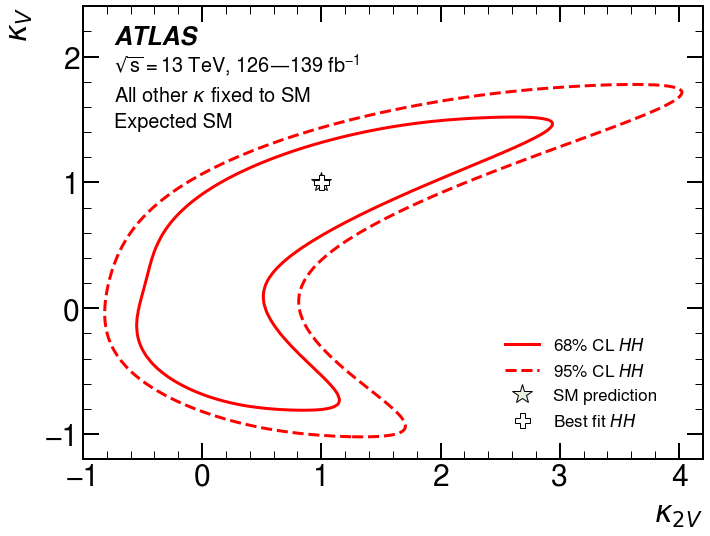

In [7]:
for status in statuses:
    plot_k2v_kv(df_2D_k2VkV, job='obs', status=status)
    plot_k2v_kv(df_2D_k2VkV, job='exp', status=status)


In [ ]:
df = {}
fix='k2V'
look='kV'
for i in df_2D_k2VkV['obs']['diHiggs'].groupby(by=fix):
    if i[0] < 0.5 or i[0] > 1:
        continue
    df[f'{fix} = {i[0]}'] = i[1]
plotter = Likelihood1DPlot(df)
ax = plotter.draw(xlabel=look, ylabel="$-2\ ln\ \Lambda$", ymax = 6, xattrib=look, yattrib='qmu')


<Figure size 432x288 with 0 Axes>

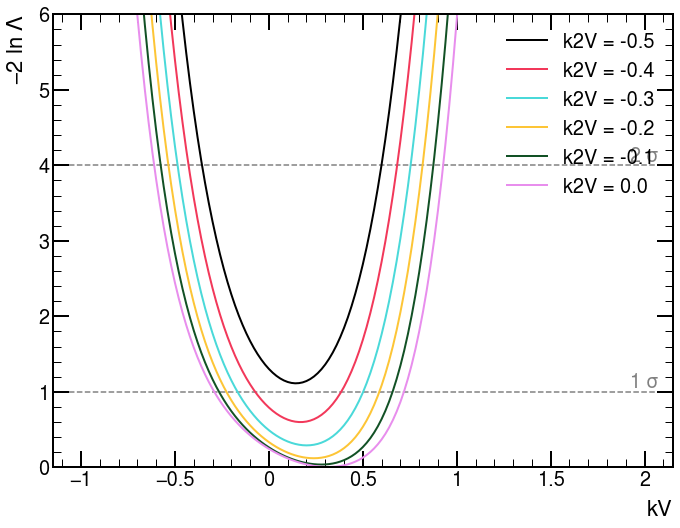

In [152]:
df = {}
fix='k2V'
look='kV'
for i in df_2D_k2VkV['obs']['diHiggs'].groupby(by=fix):
    if i[0] < -0.5 or i[0] > 0:
        continue
    df[f'{fix} = {i[0]}'] = i[1]
plotter = Likelihood1DPlot(df)
ax = plotter.draw(xlabel=look, ylabel="$-2\ ln\ \Lambda$", ymax = 6, xattrib=look, yattrib='qmu')


<Figure size 432x288 with 0 Axes>

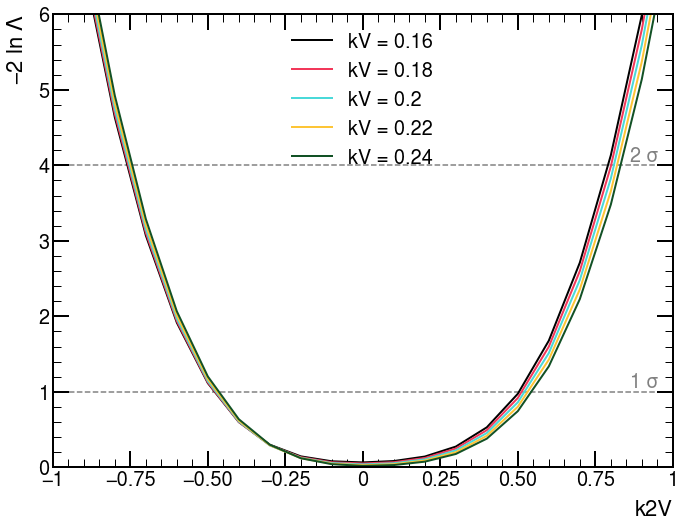

In [159]:
df = {}
fix='kV'
look='k2V'
for i in df_2D_k2VkV['obs']['diHiggs'].groupby(by=fix):
#     if i[0] not in [0, 0.2, 0.4, 0.6]:
    if i[0]<0.16 or i[0]>0.24:
        continue
    df[f'{fix} = {i[0]}'] = i[1]
plotter = Likelihood1DPlot(df)
ax = plotter.draw(xlabel=look, ylabel="$-2\ ln\ \Lambda$", xmin=-1, xmax=1, ymax = 6, xattrib=look, yattrib='qmu')


## Correlation check

In [52]:
file_path = '/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/correlation'
asimov = pd.read_json(f'{file_path}/bbtautau_asimov.json')['klambda']
obs = pd.read_json(f'{file_path}/bbtautau_obs.json')['klambda']

In [55]:
diff = asimov - obs

In [59]:
largeindex = diff[abs(diff) > 0.05].index

In [61]:
asimov[largeindex], obs[largeindex]

(k2V                                         0.424296
 alpha_THEO_XS_SCALEMTop_ggFSMHH             0.073535
 alpha_THEO_ACC_HF_ggFH                      0.265602
 alpha_SysTHEO_ACC_Zhf_SCALE                 0.092870
 alpha_SysTHEO_ACC_Zhf_GENERATOR            -0.047171
 alpha_SysTHEO_ACC_StopWt_TopInterference   -0.187157
 Name: klambda, dtype: float64,
 k2V                                        -0.105039
 alpha_THEO_XS_SCALEMTop_ggFSMHH             0.002915
 alpha_THEO_ACC_HF_ggFH                      0.019685
 alpha_SysTHEO_ACC_Zhf_SCALE                -0.006337
 alpha_SysTHEO_ACC_Zhf_GENERATOR             0.024541
 alpha_SysTHEO_ACC_StopWt_TopInterference   -0.042872
 Name: klambda, dtype: float64)

In [40]:
best_fit_path = '/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/correlation/bestfit_scan/'
channels = ['bbyy', 'bbtautau', 'bbbb']
df = {}
for chan in channels:
    df[chan] = {}
    for experiment in ['exp', 'obs']:
        df[chan][experiment] = pd.read_json(f'{best_fit_path}/{chan}/klambda_k2V_{experiment}/klambda_k2V.json')
        df[chan][experiment] = pd.read_json(f'{best_fit_path}/{chan}/klambda_k2V_{experiment}/klambda_k2V.json')

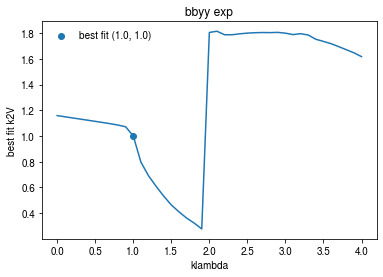

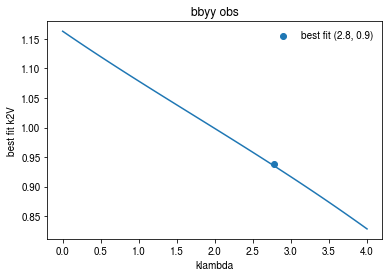

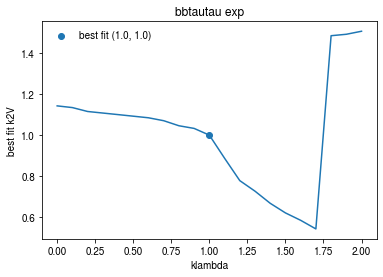

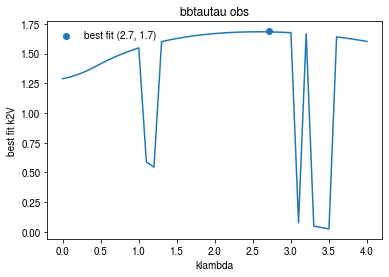

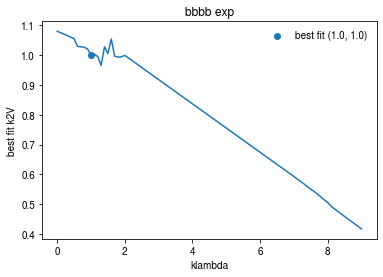

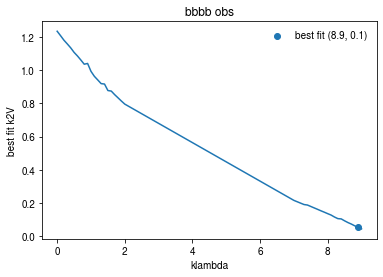

In [41]:
x, y ='klambda', 'k2V'
for chan in channels:
    for experiment in ['exp', 'obs']:
        df_nobest = df[chan][experiment].iloc[1: , :]
        df_best = df[chan][experiment].iloc[0:1, :]
        plt.plot(df_nobest[x], df_nobest[y])
        plt.scatter(df_best[x][0], df_best[y][0], label='best fit (%.1f, %.1f)'%(df_best[x][0], df_best[y][0]))
        plt.title(chan+' '+experiment)
        plt.xlabel(x)
        plt.ylabel(f'best fit {y}')
        plt.legend()
        plt.show()